In [1]:
import sys
sys.path.append('..')

In [34]:
import torch
from utils.utils import Vectorizer, LMDataset
from torch.utils.data import DataLoader
from lms.models import FFNLM

import matplotlib.pyplot as plt
import seaborn as sns

## Funciones

In [3]:
# Funciones relevantes para analizar el aprendizaje de la red neuronal


def crear_ngramas(text:str, n_gramas:int) -> list:
    '''
        Funcion que recibe un texto y un numero de n-gramas, y devuelve una lista con los n-gramas
        en minúscula a considerar dentro de la red neuronal, cada uno en formato de lista
    '''
    texto_min = text.lower()
    palabras = texto_min.split(' ')
    ngramas = []
    for i in range((len(palabras) - 1) - (n_gramas - 1)):           #se itera hasta el penúltimo n-grama
        if n_gramas == 1:
            ngramas.append([palabras[i]])                     #si el n-grama es de tamaño 1 se agrega la palabra en forma de lista a la lista de n-gramas
        else:
            ngramas.append(palabras[i:i+n_gramas])            #si el n-grama es de tamaño mayor a 1 se agrega el n-grama a la lista de n-gramas
    return ngramas


def encontrar_maxima_probabilidad(palabras:list, lm, mostrar_prob=False) -> str: 
    '''
        Funcion que recibe una lista de palabras y un modelo de lenguaje,
        y retorna la palabra siguiente con mayor probabilidad de aparecer
    '''
    prob = lm.probabilities(palabras)                           #se calcula el tensor con las probabilidades
    index_prob = torch.argmax(prob).item()                      #se obtiene el índice con el valor máximo

    palabra_sig = lm.vectorizer.tokens[index_prob]              #se obtiene el token (palabra siguiente) con el indice dentro de los tokens en el vectorizador

    if mostrar_prob:
        return f'La palabra siguiente para {palabras} es {palabra_sig} con {prob[index_prob].item()} probabilidad'

    return palabra_sig


def crear_valores_correctos(text:str, n_gramas:int) -> dict:
    '''
        Funcion que recibe un texto y un numero de n-gramas, y devuelve un 
        diccionario con la palabra siguiente asociada a cada uno 
    '''
    text = text.lower()
    palabras = text.split()
    list_gramas = crear_ngramas(text=text, n_gramas=n_gramas)                                                                           #se crean los n-gramas

    valores_correctos = {tuple(list_gramas[i]): palabras[palabras.index(list_gramas[i][-1]) + 1] for i in range(len(list_gramas))}      #para la ultima palabra en cada n_grama se mira cual es la siguiente y se le asigna
    
    return valores_correctos
   

def accuracy(text:str, lm, mostrar_correctos=False) -> float:
    '''
        Funcion que recibe un texto y un modelo, y calcula 
        el porcentaje de aciertos en base a los esperados
    '''
    valores_correctos = crear_valores_correctos(text=text, n_gramas=lm.window_length)   #se crea el diccionario de valores correctos                                              
    list_gramas = crear_ngramas(text=text, n_gramas=lm.window_length)                   #se crea la lista con los n-gramas

    lista_correctos = []
    total_correctos = 0

    for palabras in list_gramas:
        palabra_sig = encontrar_maxima_probabilidad(palabras=palabras, lm=lm)
        if valores_correctos[tuple(palabras)] == palabra_sig:                           #se verifica que la palabra siguiente esperada y la obtenida sean iguales
            lista_correctos.append(palabras)
            total_correctos+=1

    if mostrar_correctos:
        print(lista_correctos)
    
    return total_correctos/len(list_gramas)

## Ejemplo 1

In [4]:
texto = 'Juan Santiago Nicolás'

num_embeddings = 4 + len(texto.split(' '))
num_dim = 2
embeddigns = torch.nn.Embedding(
	num_embeddings=num_embeddings,
	embedding_dim=num_dim
)

vec = Vectorizer(
	texto=texto,
	embeddings=embeddigns
)

window_length = 1
hidden_size = 4
lm = FFNLM(
	vectorizer=vec,
	window_length=window_length,
	hidden_size=hidden_size
)

In [5]:
print(crear_ngramas(text=texto, n_gramas=window_length))
print(crear_valores_correctos(text=texto, n_gramas=window_length))

print(encontrar_maxima_probabilidad(palabras=['santiago'], lm=lm, mostrar_prob=True))
print(accuracy(text=texto, lm=lm))

[['juan'], ['santiago']]
{('juan',): 'santiago', ('santiago',): 'nicolás'}
La palabra siguiente para ['santiago'] es <unk> con 0.243729367852211 probabilidad
0.0


<Axes: >

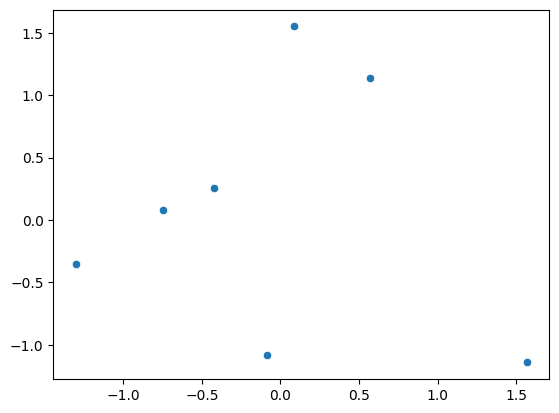

In [6]:
embedding_matrix = embeddigns.weight.detach().numpy()
sns.scatterplot(x=embedding_matrix[:,0], y=embedding_matrix[:,1])

In [7]:
lm.perplexity(text=texto)

7.3094746916933095

100%|██████████| 500/500 [00:01<00:00, 361.99it/s]


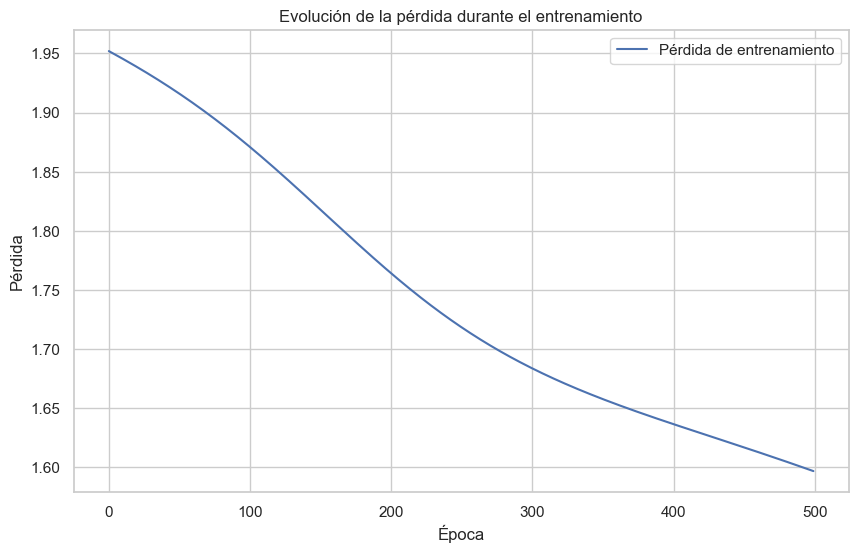

In [8]:
batch_size = 2
parameters = {
	"learning_rate":1e-4,
	"window_length":window_length,
	"batch_size":batch_size,
	"num_epochs":500
}
lm.train(
	texto=texto,
	parametros=parameters
)

In [9]:
texto

'Juan Santiago Nicolás'

In [10]:
print(encontrar_maxima_probabilidad(palabras=['santiago'], lm=lm, mostrar_prob=True))
print(accuracy(text=texto, lm=lm, mostrar_correctos=True))

La palabra siguiente para ['santiago'] es nicolás con 0.5498129725456238 probabilidad
[['juan'], ['santiago']]
1.0


<Axes: >

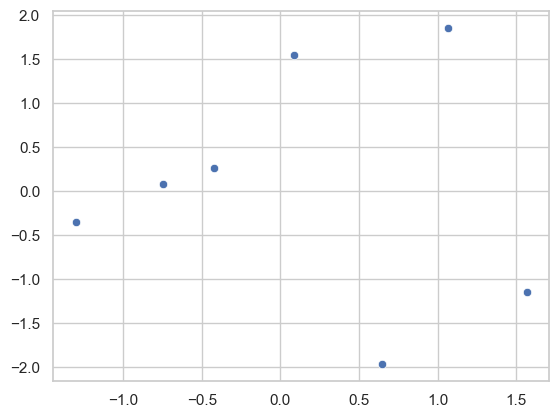

In [11]:
sns.scatterplot(x=embedding_matrix[:,0], y=embedding_matrix[:,1])

In [12]:
lm.perplexity(text=texto)

1.9467301340446488

## Ejemplo 2

In [13]:
texto = ' '.join([str(x) for x in range(10)])

num_embeddings = 4 + len(texto.split(' '))
num_dim = 1
embeddigns = torch.nn.Embedding(
	num_embeddings=num_embeddings,
	embedding_dim=num_dim
)

vec = Vectorizer(
	texto=texto,
	embeddings=embeddigns
)

window_length = 2
hidden_size = 4
lm = FFNLM(
	vectorizer=vec,
	window_length=window_length,
	hidden_size=hidden_size
)

In [14]:
texto

'0 1 2 3 4 5 6 7 8 9'

In [15]:
print(crear_valores_correctos(text=texto, n_gramas=window_length))

{('0', '1'): '2', ('1', '2'): '3', ('2', '3'): '4', ('3', '4'): '5', ('4', '5'): '6', ('5', '6'): '7', ('6', '7'): '8', ('7', '8'): '9'}


In [16]:
print(encontrar_maxima_probabilidad(palabras=['0','1'], lm=lm, mostrar_prob=True))
print(accuracy(text=texto, lm=lm))
print(lm.perplexity(text=texto))

La palabra siguiente para ['0', '1'] es <unk> con 0.12066825479269028 probabilidad
0.0
16.032722150231976


100%|██████████| 2000/2000 [00:11<00:00, 171.46it/s]


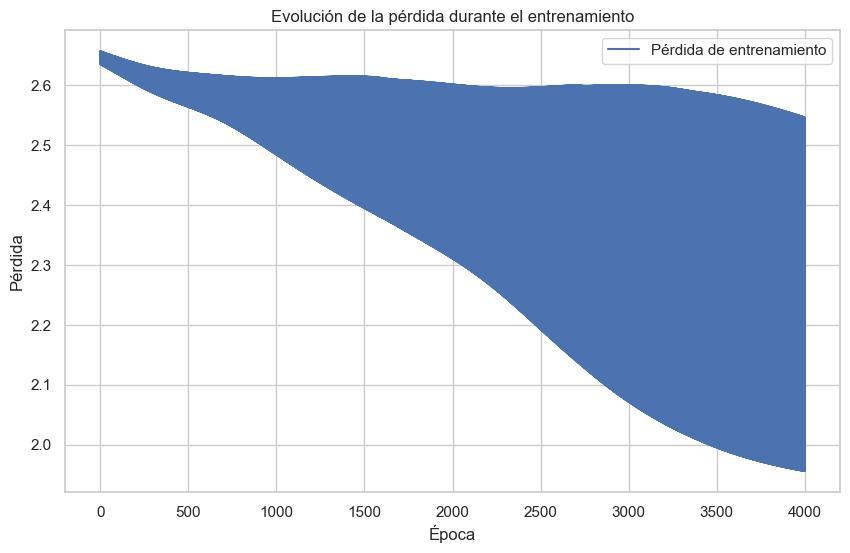

In [17]:
batch_size = 4
parameters = {
	"learning_rate":1e-4,
	"window_length":window_length,
	"batch_size":batch_size,
	"num_epochs":2000
}
lm.train(
	texto=texto,
	parametros=parameters
)

In [18]:
print(encontrar_maxima_probabilidad(palabras=['0','1'], lm=lm, mostrar_prob=True), end='\n\n')
print(accuracy(text=texto, lm=lm, mostrar_correctos=True), end='\n\n')
print(lm.perplexity(text=texto))

La palabra siguiente para ['0', '1'] es 2 con 0.41881588101387024 probabilidad

[['0', '1'], ['4', '5'], ['5', '6'], ['6', '7'], ['7', '8']]
0.625

3.0993302020829954


## Ejemplo 3

In [19]:
texto = ' '.join([str(x) for x in range(100)])

num_embeddings = 4 + len(texto.split(' '))
num_dim = 6
embeddigns = torch.nn.Embedding(
	num_embeddings=num_embeddings,
	embedding_dim=num_dim
)

vec = Vectorizer(
	texto=texto,
	embeddings=embeddigns
)

window_length = 4
hidden_size = 4
lm = FFNLM(
	vectorizer=vec,
	window_length=window_length,
	hidden_size=hidden_size
)

In [20]:
print(crear_valores_correctos(text=texto, n_gramas=window_length))

{('0', '1', '2', '3'): '4', ('1', '2', '3', '4'): '5', ('2', '3', '4', '5'): '6', ('3', '4', '5', '6'): '7', ('4', '5', '6', '7'): '8', ('5', '6', '7', '8'): '9', ('6', '7', '8', '9'): '10', ('7', '8', '9', '10'): '11', ('8', '9', '10', '11'): '12', ('9', '10', '11', '12'): '13', ('10', '11', '12', '13'): '14', ('11', '12', '13', '14'): '15', ('12', '13', '14', '15'): '16', ('13', '14', '15', '16'): '17', ('14', '15', '16', '17'): '18', ('15', '16', '17', '18'): '19', ('16', '17', '18', '19'): '20', ('17', '18', '19', '20'): '21', ('18', '19', '20', '21'): '22', ('19', '20', '21', '22'): '23', ('20', '21', '22', '23'): '24', ('21', '22', '23', '24'): '25', ('22', '23', '24', '25'): '26', ('23', '24', '25', '26'): '27', ('24', '25', '26', '27'): '28', ('25', '26', '27', '28'): '29', ('26', '27', '28', '29'): '30', ('27', '28', '29', '30'): '31', ('28', '29', '30', '31'): '32', ('29', '30', '31', '32'): '33', ('30', '31', '32', '33'): '34', ('31', '32', '33', '34'): '35', ('32', '33', '3

In [21]:
print(len(crear_ngramas(text=texto, n_gramas=4)))

96


In [22]:
print(encontrar_maxima_probabilidad(palabras=['5','6','7','8'], lm=lm, mostrar_prob=True))
print(accuracy(text=texto, lm=lm))
print(lm.perplexity(text=texto))

La palabra siguiente para ['5', '6', '7', '8'] es 20 con 0.02245068922638893 probabilidad
0.0
111.1178642192824


100%|██████████| 1000/1000 [00:28<00:00, 34.75it/s]


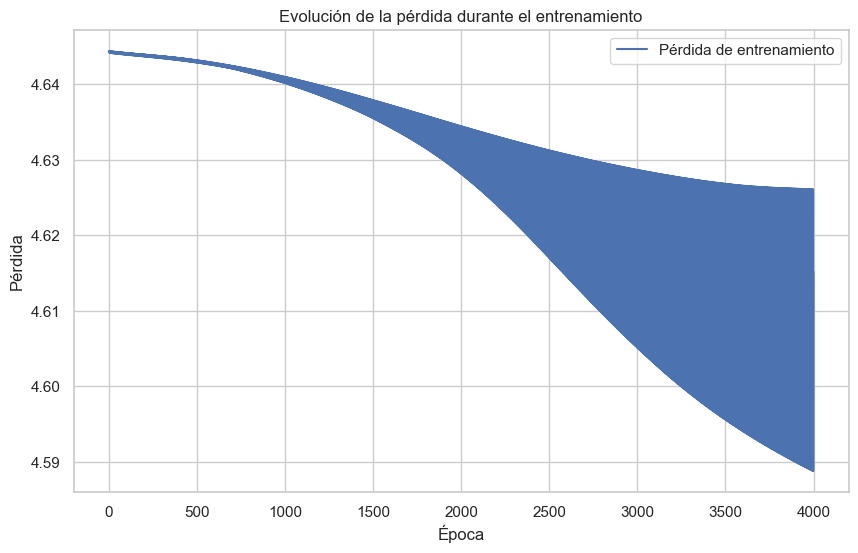

In [23]:
batch_size = 24
parameters = {
	"learning_rate":1e-2,
	"window_length":window_length,
	"batch_size":batch_size,
	"num_epochs":1000
}
lm.train(
	texto=texto,
	parametros=parameters
)

In [24]:
print(encontrar_maxima_probabilidad(palabras=['5','6','7','8'], lm=lm), end='\n\n')
print(accuracy(text=texto, lm=lm, mostrar_correctos=True), end='\n\n')
print(lm.perplexity(text=texto))

9

[['5', '6', '7', '8'], ['10', '11', '12', '13'], ['53', '54', '55', '56'], ['68', '69', '70', '71'], ['71', '72', '73', '74'], ['75', '76', '77', '78'], ['80', '81', '82', '83']]
0.07291666666666667

38.91290185707143


### Ejemplo 4

In [25]:
texto = 'Juan Nicolás Edgar Juan Nicolás Daniel Juan Nicolás Santiago'

num_embeddings = 4 + len(texto.split(' '))
num_dim = 2
embeddigns = torch.nn.Embedding(
	num_embeddings=num_embeddings,
	embedding_dim=num_dim
)

vec = Vectorizer(
	texto=texto,
	embeddings=embeddigns
)

window_length = 3
hidden_size = 4
lm = FFNLM(
	vectorizer=vec,
	window_length=window_length,
	hidden_size=hidden_size
)

In [26]:
print(crear_valores_correctos(text=texto, n_gramas=window_length))

{('juan', 'nicolás', 'edgar'): 'juan', ('nicolás', 'edgar', 'juan'): 'nicolás', ('edgar', 'juan', 'nicolás'): 'edgar', ('juan', 'nicolás', 'daniel'): 'juan', ('nicolás', 'daniel', 'juan'): 'nicolás', ('daniel', 'juan', 'nicolás'): 'edgar'}


In [27]:
print(encontrar_maxima_probabilidad(palabras=['juan','nicolás','edgar'], lm=lm, mostrar_prob=True))
print(accuracy(text=texto, lm=lm))
print(lm.perplexity(text=texto))

La palabra siguiente para ['juan', 'nicolás', 'edgar'] es <pad> con 0.25685834884643555 probabilidad
0.0
13.709893140284686


100%|██████████| 500/500 [00:04<00:00, 102.56it/s]


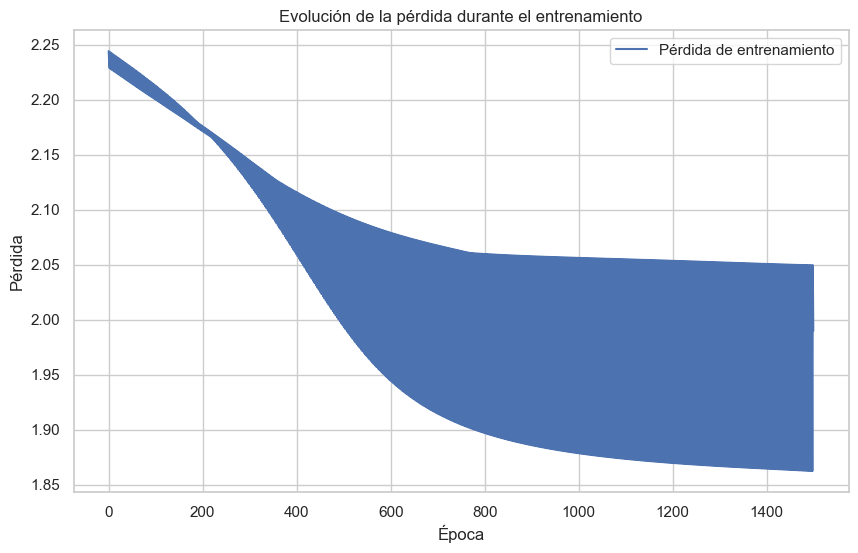

In [28]:
batch_size = 2
parameters = {
	"learning_rate":1e-4,
	"window_length":window_length,
	"batch_size":batch_size,
	"num_epochs":500
}
lm.train(
	texto=texto,
	parametros=parameters
)

In [29]:
texto

'Juan Nicolás Edgar Juan Nicolás Daniel Juan Nicolás Santiago'

In [30]:
print(encontrar_maxima_probabilidad(palabras=['juan','nicolás','edgar'], lm=lm), end='\n\n')
print(accuracy(text=texto, lm=lm, mostrar_correctos=True), end='\n\n')
print(lm.perplexity(text=texto))

nicolás

[['nicolás', 'edgar', 'juan'], ['nicolás', 'daniel', 'juan']]
0.3333333333333333

3.247260922312277


In [31]:
window_length = 1
batch_size = 1
ds = LMDataset(
	texto=texto, 
	vectorizer=vec,
	window_length=window_length)
ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
for ds_features, ds_labels in ds_loader:
	ds_features = [[x[i] for x in ds_features] for i in range(batch_size)]
	print(ds_features, ds_labels)

[['juan']] ('nicolás',)
[['nicolás']] ('edgar',)
[['edgar']] ('juan',)
[['juan']] ('nicolás',)
[['nicolás']] ('daniel',)
[['daniel']] ('juan',)
[['juan']] ('nicolás',)
[['nicolás']] ('santiago',)


In [32]:
print(crear_valores_correctos(text=texto, n_gramas=1))

{('juan',): 'nicolás', ('nicolás',): 'edgar', ('edgar',): 'juan', ('daniel',): 'juan'}


In [33]:
texto

'Juan Nicolás Edgar Juan Nicolás Daniel Juan Nicolás Santiago'